In [1]:
import parser
from pprint import pprint
from itertools import chain

from IPython.display import Image, display
from lark import Lark, Tree, Token, Transformer, v_args
from lark import tree as larkTree
from lark.indenter import Indenter

import os

NOTES_FOLDER = './note_files/'
NOTE_PATHS = [x for x in os.listdir(NOTES_FOLDER) if x.endswith('.md')]

def display_tree(t, filename='viz.png'):
    larkTree.pydot__tree_to_png(t, filename)
    display(Image(filename))
    os.remove(filename)

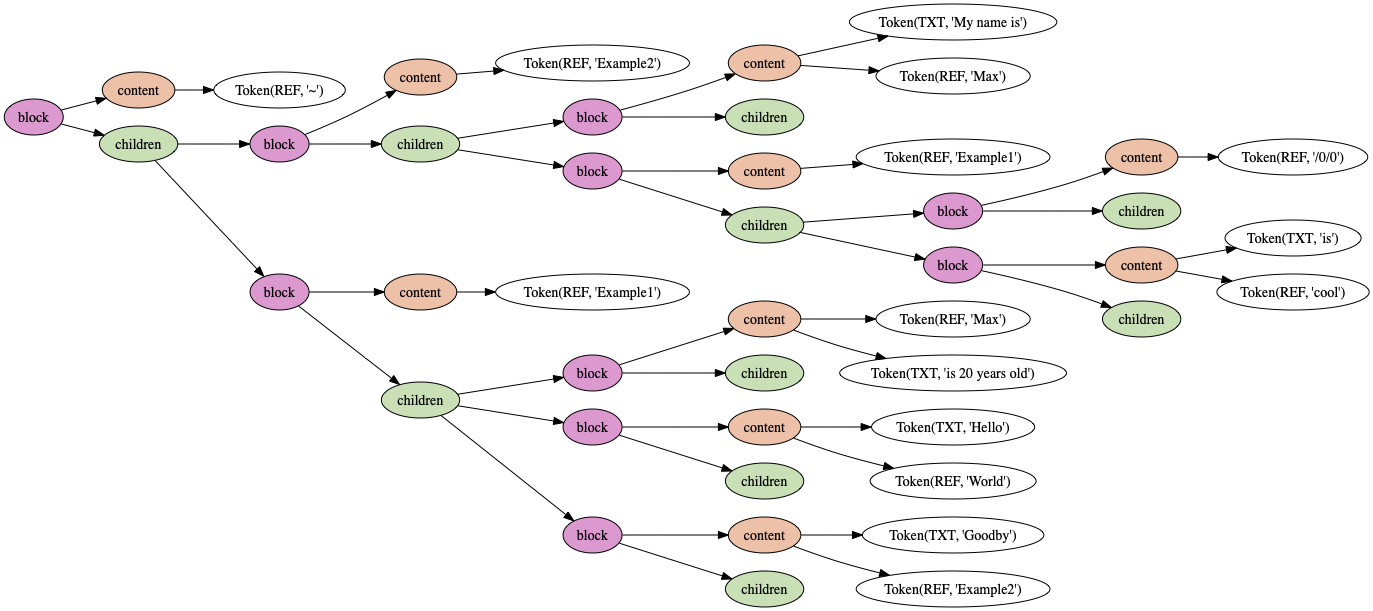

In [2]:
class TreeIndenter(Indenter):
    NL_type = '_NL'
    OPEN_PAREN_types = ["OPEN_REF"]
    CLOSE_PAREN_types = ["CLOSE_REF"]
    INDENT_type = '_INDENT'
    DEDENT_type = '_DEDENT'
    tab_len = 8
    
class BTransformer(Transformer):
    def text(self, items):
        return Token('TXT', ' '.join(items))
    
    def reference(self, items):
        return Token('REF', ' '.join(items))


class Block:
    
    def __init__(self, content, children=[]):
        self.content = content
        self.children = children

        
    def fromTree(blockTree):
        content = blockTree.children[0].children
        children = blockTree.children[1].children
        children = [Block.fromTree(x) for x in children]
                
        return Block(content, children)
    
    def toTree(self):
        children_node = Tree(data='children', children=[x.toTree() for x in self.children])
        content_node = Tree(data='content', children=self.content)
        return Tree(data='block',
                   children=[content_node, children_node])
    
    def to_dict(self):
        children = [x.to_dict() for x in self.children]
        content = []
        for token in self.content:
            content.append({
                'type': token.type,
                'value': str(token)
            })
        return {
            'type': 'block',
            'children': children,
            'content': content
        }
    
    def flatten(self, path=''):
        results = {}
        block_text = self.content
        block_children = self.children
        results[path] = self
        for i, b in enumerate(block_children):
            results.update(b.flatten(path + '/' + str(i)))
        return results
    
    def get_refs(self, depth=0):
        all_refs = set()
        for token in self.content:
            if token.type == 'REF':
                all_refs.add(str(token))
        if depth > 0:
            for block in self.children:
                all_refs.update(block.get_refs(depth - 1))
        return all_refs
    
    def get_by_ref(self, ref_text, recursive=False):
        results = []
        for token in self.content:
            if token.type == 'REF' and token == ref_text:
                results.append(self)
        if recursive:
            for block in self.children:
                results += block.get_by_ref(ref_text, recursive)
        return results
    
    def get_by_path(self, path):
        a = path.split('/')[0]
        r = '/'.join(path.split('/')[1:])
        if a == '' and len(r) == 0:
            return self
        elif a == '' and len(path.split('/')) > 1:
            return self.get_by_path(r)
        elif a.isnumeric():
            return self.children[int(a)].get_by_path(r)
        
    def show(self):
        display_tree(self.toTree())
        
    def __iter__(self):
        "implement the iterator protocol"
        for v in chain(*map(iter, self.children)):
            yield v
        yield self
        
    def __repr__(self):
        return ' '.join(self.content)

    
GRAMMAR = r"""
    ?start: (_NL* block)* -> start
    block: "- " content _NL children
    children: [_INDENT block* _DEDENT]
    
    content: (text|reference)+
    text: (WORD)+
    reference: "[[" (WORD)+ "]]"
    
    WORD: /([^(\[|\]|\s)])/+
    
    %import common.LETTER
    %import common.DIGIT
    %import common.WS_INLINE
    %declare _INDENT _DEDENT
    %ignore WS_INLINE
    _NL: /(\r?\n(\s)*)+/
"""

PARSER = Lark(
    GRAMMAR,
    parser='lalr',
    postlex=TreeIndenter(),
    transformer=BTransformer())


def parse_blocks(text):
    return PARSER.parse(text).children


def parse_notefile(note_path):
    text = open(note_path).read() + '\n'
    note_title = os.path.basename(note_path).replace('.md', '')
    blocks = [Block.fromTree(x) for x in parse_blocks(text)]
    root_text = [Token('REF', note_title)]
    return Block(content=root_text, children=blocks)


def parse_notefiles(folder_path):
    paths = [x for x in os.listdir(folder_path) if x.endswith('.md')]
    note_blocks = []
    for path in paths:
        note_title = path.replace('.md', '')
        note_tree = parse_notefile(NOTES_FOLDER + path)
        note_blocks.append(note_tree)
    return Block(content=[Token('REF', value='~')], children=note_blocks)
    

NOTES_FOLDER = './note_files/'
notes_data = parse_notefiles(NOTES_FOLDER)
notes_data.show()

In [3]:
notes_data.get_refs(depth=10)

{'/0/0', 'Example1', 'Example2', 'Max', 'World', 'cool', '~'}

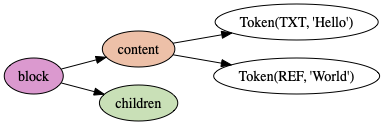

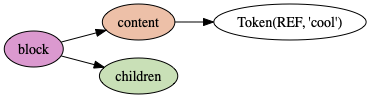

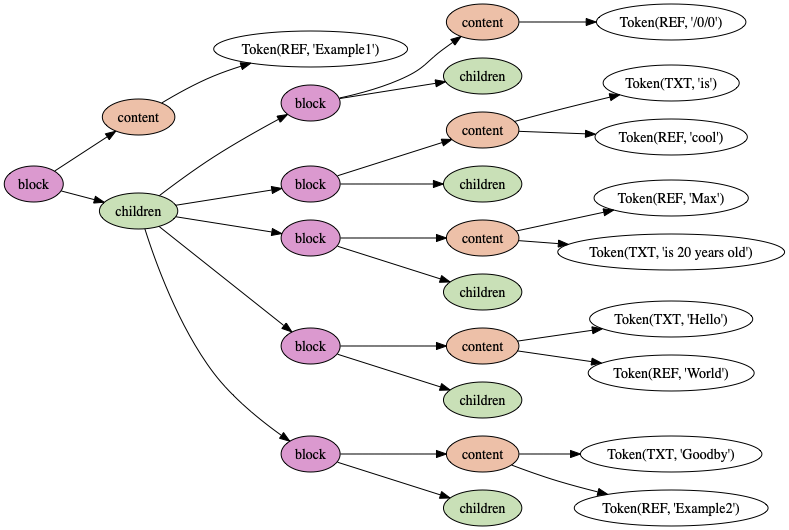

In [4]:
def resolve_ref_occurences(ref_text, block):
    occurences = []
    for b in block:
        for ref in b.get_refs():
            if ref == ref_text:
                occurences.append(b)
    return occurences


def resolve_ref_block(ref_text, root_block):
    occurences = root_block.get_by_ref(ref_text, recursive=True)
    block = None
    if ref_text[0] == '/': # get block by path
        return root_block.get_by_path(ref_text)
    else: # get block by content
        aggregate_children = []
        name = None
        for b in occurences:
            block_text = b.content
            if len(block_text) == 1 and block_text[0] == ref_text: # references a title block
                aggregate_children += b.children
                name = b.content
        if name is not None:
            block = Block(name, aggregate_children)
    if block is None and len(occurences) > 0: # construct an empty block
        block = Block(content=[Token('REF', value=ref_text)])
    return block
    

resolve_ref_block('/1/1', notes_data).show()
resolve_ref_block('cool', notes_data).show() # Need to join disconnected blocks!
resolve_ref_block('Example1', notes_data).show()


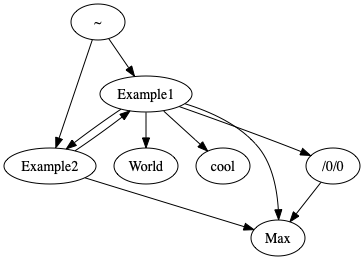

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
G = nx.DiGraph()

all_references = notes_data.get_refs(depth=100)
for x in all_references:
    G.add_node(x)
    block = resolve_ref_block(x, notes_data)
    for ref in block.get_refs(depth=1):
        if x != ref:
            G.add_edge(x, ref)

options = {
    'node_color': 'lightblue',
    'node_size': 100,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

def display_graph(g, filename='viz.png'):
    A = to_agraph(g)
    A.layout('dot')
    A.draw(filename)
    display(Image(filename))
    os.remove(filename)

display_graph(G)
